In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip drive/MyDrive/PhC-C2DH-U373.zip

Archive:  drive/MyDrive/PhC-C2DH-U373.zip
replace PhC-C2DH-U373/01/t000.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from tensorflow.keras import backend as K

In [4]:
from PIL import Image

# Cargo Train y Val

Train será aumentado

In [5]:
train_path = Path("PhC-C2DH-U373/01/").glob("**/*tif")
val_path = Path("PhC-C2DH-U373/02/").glob("**/*tif")

In [6]:
train_images = list()
train_masks = list()
for file in train_path:
    train_images.append(np.array(Image.open(file)).reshape(1,520,696))
    train_masks.append(np.array(Image.open(f'PhC-C2DH-U373/01_ST/SEG/man_seg{file.name[1:]}')).reshape(1,520,696))

val_images = list()
val_masks = list()

for file in val_path:
    val_images.append(np.array(Image.open(file)).reshape(1,520,696))
    val_masks.append(np.array(Image.open(f'PhC-C2DH-U373/02_ST/SEG/man_seg{file.name[1:]}')).reshape(1,520,696))

In [7]:
train_images = np.vstack(train_images)/255
train_masks = 1*(np.vstack(train_masks) > 0)
val_images = np.vstack(val_images)/255
val_masks = 1*(np.vstack(val_masks) >0 )

# Imágenes de train sin aumentar

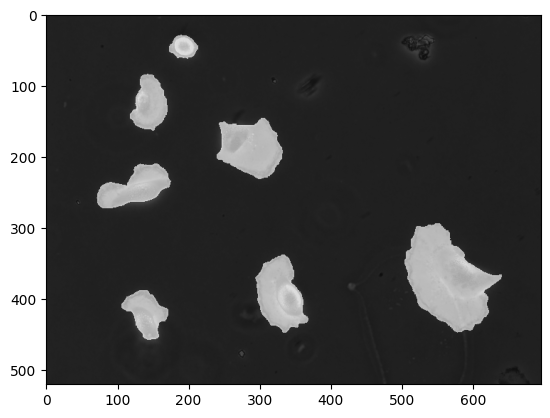

In [8]:
idx = 100
plt.imshow(train_images[idx], vmin=0, vmax=1, cmap="gray")
plt.imshow(train_masks[idx], vmin=0, vmax=1, cmap="gray",alpha=0.6)
plt.show()

# Armo datasets de tensorflow y aumento

Para mantener sincronizada la aumentación entre la imagen y la máscara, armo una entrada de 4 canales que de descompondrán durante el entrenamiento.

In [9]:
train_images.shape

(115, 520, 696)

In [10]:
train_masks.shape

(115, 520, 696)

In [11]:
x_train = np.stack((train_images, train_masks ),axis=-1)
x_val = np.stack((val_images, val_masks ),axis=-1)

In [12]:
x_train.shape

(115, 520, 696, 2)

In [13]:
x_train[0,:,:,0].max()

0.7254901960784313

In [14]:
len(x_train)

115

In [15]:
x_val.shape

(115, 520, 696, 2)

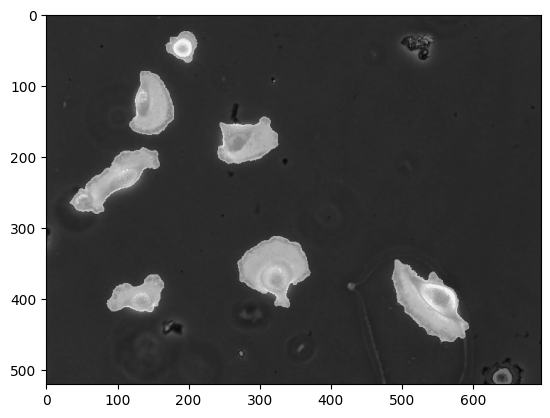

In [16]:
plt.imshow(x_train[0,:,:,0], cmap="gray")
plt.imshow(x_train[0,:,:,1], cmap="gray", alpha = 0.5)

In [17]:
from tensorflow.keras.models import Sequential

# Armo la red de preprocesamiento para hacer aumentación en la GPU que no tengo

In [18]:
def get_preproc():
    return Sequential([
        tf.keras.layers.RandomCrop(512,512),
        tf.keras.layers.RandomFlip(mode='horizontal_and_vertical'),
        #tf.keras.layers.RandomZoom((-0.1,0.3)),
        #tf.keras.layers.RandomTranslation((-0.5, 0.5), (-0.5,0.5)),
        #tf.keras.layers.RandomRotation((0,1)),
        #tf.keras.layers.RandomZoom((0.5,0.5)),
        ])

def get_preproc_val():
    return Sequential([
        tf.keras.layers.CenterCrop(512,512),
        ])

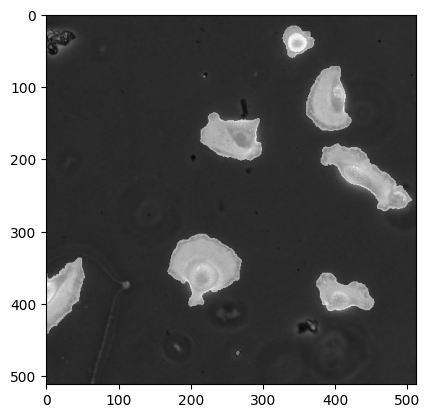

In [19]:
preproc = get_preproc()
aux_elem = preproc(x_train[0])
plt.imshow(aux_elem[:,:,0], cmap="gray")
plt.imshow(aux_elem[:,:,1], cmap="gray", alpha = 0.5)

In [20]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [21]:
class SegmentationModel(Model):
    def __init__(self, red_preproc, red_segmentacion, red_preproc_val):
        super().__init__()
        self.red_segmentacion = red_segmentacion
        self.red_preproc = red_preproc
        self.red_preproc_val = red_preproc_val
        self.loss_tracker = metrics.Mean(name="loss")
        self.dice = False


    def call(self, inputs):
        #img_mask = self.red_preproc = red_preproc(inputs)
        return self.red_segmentacion(inputs[:,:,:1])

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            data_aug = self.red_preproc(data)
            loss = self._compute_loss(data_aug)
            #print(K.mean(loss))

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.red_segmentacion.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.red_segmentacion.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        data_preproc = self.red_preproc_val(data)
        loss = self._compute_loss(data_preproc)
        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        #aux = self.red_preproc(data)
        mask_out = self.red_segmentacion(data[:,:,:,:1])
        #print(mask_out.shape)
        #print(data[:,:,:,1:2].numpy())
        if self.dice == True:
            loss = dice_loss(data[:,:,:,1:2], mask_out)
        else:
            loss = tf.keras.losses.binary_crossentropy(data[:,:,:,1:2], mask_out)
        return loss

    # property
    # def metrics(self):
    #     # We need to list our metrics here so the `reset_states()` can be
    #     # called automatically.
    #     return [self.loss_tracker]

# Armo Red U-Net

La red U-Net es una red convolucional que tiene una arquitectura simétrica, con una parte descendente y una parte ascendente. La parte descendente es similar a la de una red convolucional normal, con capas convolucionales y pooling. La parte ascendente es similar a la de una red convolucional inversa, con capas de upsampling y convoluciones. La parte ascendente tiene conexiones con la parte descendente, de manera que se pueden utilizar las características aprendidas en la parte descendente para reconstruir la imagen.

En este caso se utiliza para realizar la segmentación de las células, de manera que la parte descendente aprende a detectar las características de las células, y la parte ascendente utiliza esas características para reconstruir la imagen segmentada.

In [22]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Concatenate, MaxPooling2D, UpSampling2D,Conv2DTranspose
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers.experimental import RMSprop

In [23]:
img_shape = (512, 512, 1)
def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same')(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same')(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu',
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)

In [49]:
preproc_unet= get_preproc()
preproc_unet_val= get_preproc_val()
red_unet = UNet(
    img_shape,
    start_ch = 16,
    dropout = False,
    residual = True
)
model_unet = SegmentationModel(preproc_unet, red_unet,preproc_unet_val)

In [50]:
red_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

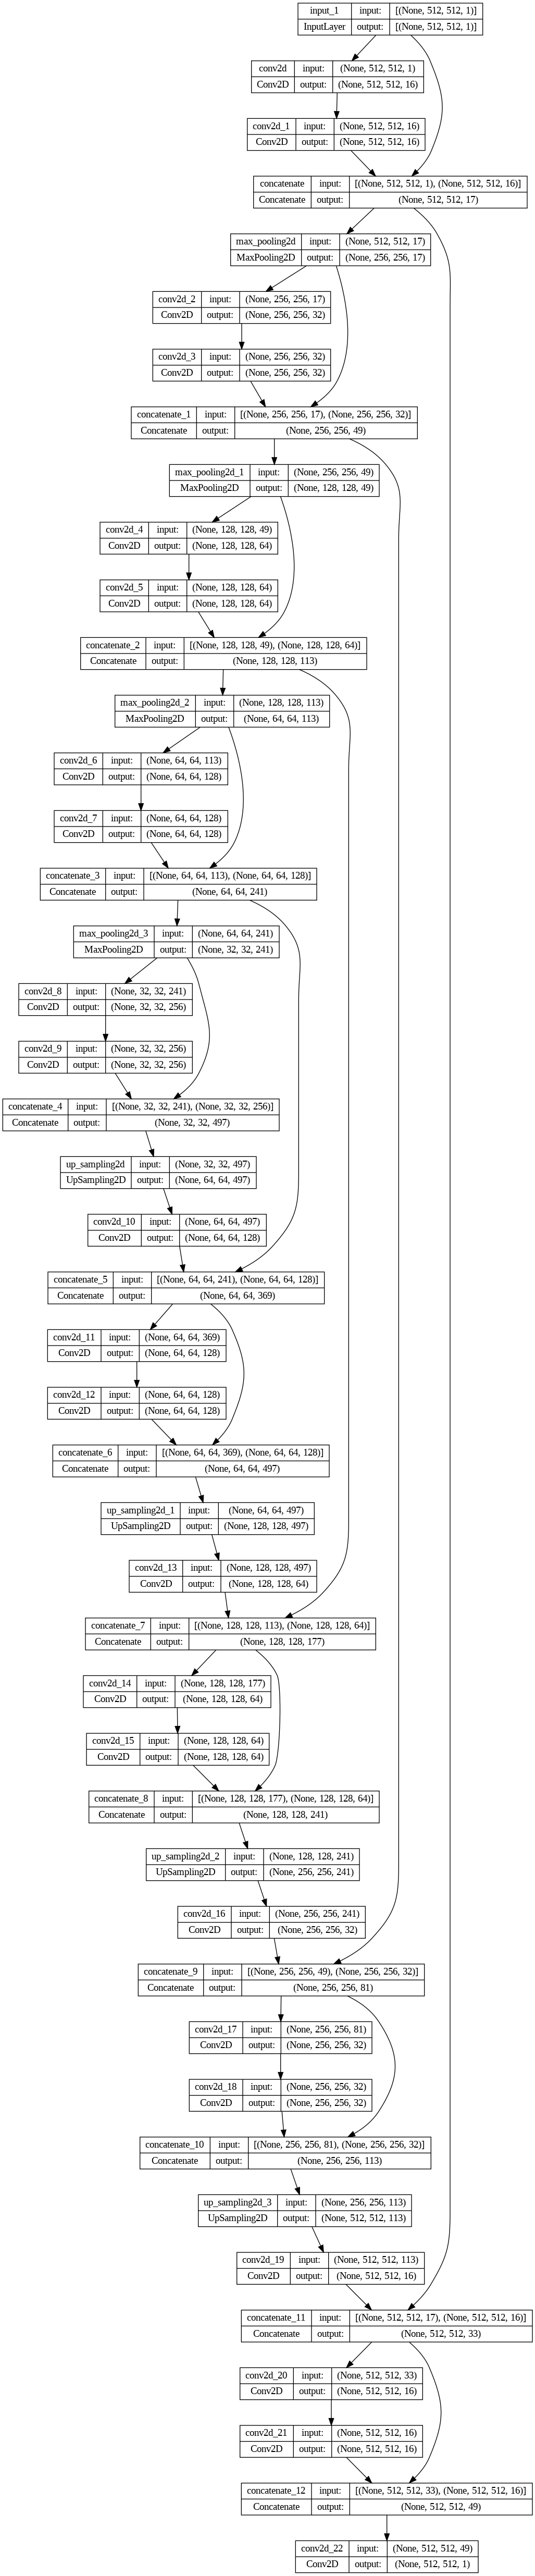

In [40]:
plot_model(red_unet, show_shapes=True, show_layer_names=True, to_file='red_unet.png')

In [51]:
model_unet.compile(optimizer= tf.keras.optimizers.Adam(1e-3))

In [52]:
early_stopping = EarlyStopping(patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

In [53]:
history = model_unet.fit(np.vstack([x_train, x_val]), batch_size=8, epochs=100, validation_split=0.5, verbose=1, callbacks=[early_stopping])

Epoch 1/100
15/15 [==============================] - 21s 895ms/step - loss: 0.5771 - val_loss: 0.1828
Epoch 2/100
15/15 [==============================] - 15s 990ms/step - loss: 0.3551 - val_loss: 0.1977
Epoch 3/100
15/15 [==============================] - 12s 791ms/step - loss: 0.3310 - val_loss: 0.1784
Epoch 4/100
15/15 [==============================] - 12s 784ms/step - loss: 0.2603 - val_loss: 0.4170
Epoch 5/100
15/15 [==============================] - 12s 781ms/step - loss: 0.3597 - val_loss: 0.2091
Epoch 6/100
15/15 [==============================] - 12s 785ms/step - loss: 0.2805 - val_loss: 0.3833
Epoch 7/100
15/15 [==============================] - 12s 783ms/step - loss: 0.3474 - val_loss: 0.1175
Epoch 8/100
15/15 [==============================] - 12s 789ms/step - loss: 0.2092 - val_loss: 0.0826
Epoch 9/100
15/15 [==============================] - 12s 793ms/step - loss: 0.1374 - val_loss: 0.0876
Epoch 10/100
15/15 [==============================] - 12s 791ms/step - loss: 0.108

In [44]:
x_val.shape

(115, 520, 696, 2)

In [45]:
aux = preproc_unet_val(x_val[0:20,:,:,:])
pred_unet = red_unet(aux[0:20,:,:,0])
pred_unet.shape

TensorShape([20, 512, 512, 1])

In [46]:
aux = np.array(aux, dtype='float64')
pred_unet = np.array(pred_unet, dtype='float64')
dice = []
for i in range(20):
    dice += [dice_coef(aux[i,:,:,1], pred_unet[i,:,:,0], smooth=1e-6)]
np.array(dice).mean()

0.8600456349231175

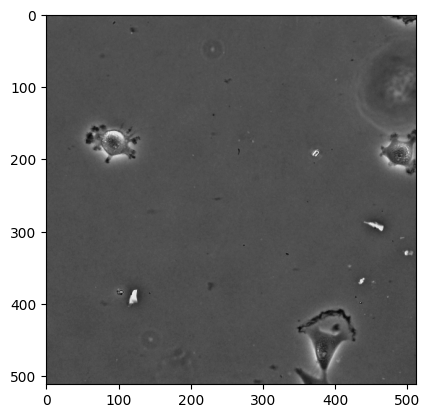

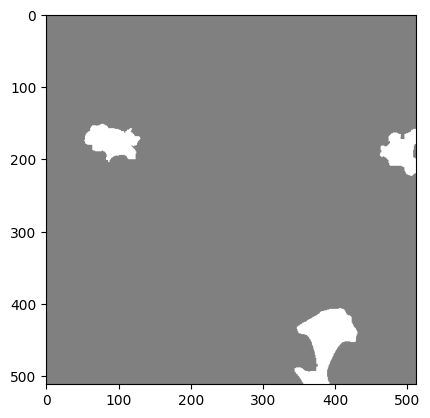

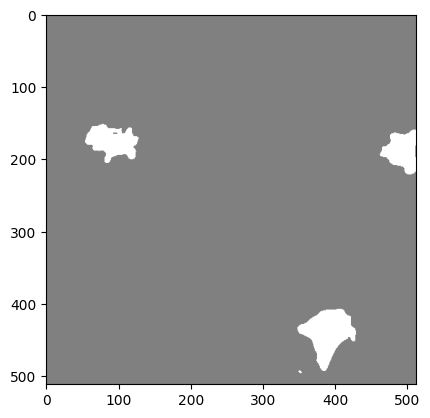

In [47]:
plt.imshow(aux[0,:,:,0], cmap="gray")
plt.show()
plt.imshow(aux[0,:,:,1], cmap="gray", alpha = 0.5)
plt.show()
plt.imshow(pred_unet[0,:,:,0]>0.7, cmap="gray", alpha = 0.5)
plt.show()

In [48]:
tf.keras.backend.clear_session()